In [1]:
import numpy as np 
import pandas as pd 
from csaps import csaps 
import matplotlib.pyplot as plt 

# Add the src directory to the Python path
import sys
import os
sys.path.append(os.path.abspath('../src'))

# Load .py files
import common_functions as func
import calibration_plots as p
import configs as c

In [ ]:
def row_normalize(matrix):
    
    for age_layer in range(matrix.shape[0]):
        layer = matrix[age_layer, :, :]
        non_diag_sum = np.sum(layer, axis=1) - np.diagonal(layer)

        # Scale rows if non-diagonal sum exceeds 1
        scaling_factors = np.clip(1 / non_diag_sum, None, 1)
        layer *= scaling_factors[:, np.newaxis]  # Scale entire row

        # Adjust diagonal elements to ensure each row sums to 1
        np.fill_diagonal(layer, np.maximum(0, 1 - np.sum(layer, axis=1) + np.diagonal(layer)))

        # Update the matrix for the current age layer
        matrix[age_layer, :, :] = layer

    return matrix.clip(0.0, 1.0)

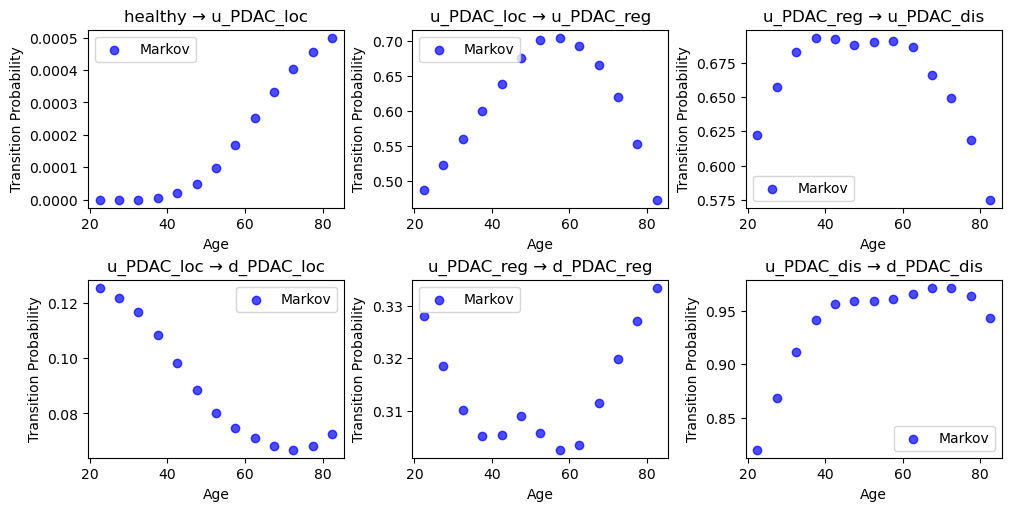

In [3]:
mat = np.load("../out/avg/tmats/20250106_1626_tmat.npy")
p.plot_params(mat, show_plot=True)

In [9]:
def plot_params(markov_tmat, treeage_tmat=None, save_imgs=False, show_plot=False, outpath=None, timestamp=None):
    
    params = c.transitions_itos  # Transition state mappings
    n_params = len(params)  # Number of transition parameters
    
    # Define grid layout
    ncols = 3
    nrows = (n_params + ncols - 1) // ncols  # Ensure enough rows for all parameters
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 2.5 * nrows), constrained_layout=True)
    axes = axes.flatten()  # Flatten axes array for easier indexing
    age_bucket_midpts = [22.5, 27.5, 32.5, 37.5, 42.5, 47.5, 52.5, 57.5, 62.5, 67.5, 72.5, 77.5, 82.5]
    if markov_tmat.shape[0] == 65:
        markov_tmat_5y = markov_tmat[2::5, :, :]
    else: 
        markov_tmat_5y = markov_tmat
    
    for ax, ((from_idx, to_idx), (from_state, to_state)) in zip(axes, params.items()):
        # Plot TreeAge (line) and Markov (points)
        if treeage_tmat is not None:
            ax.plot(np.linspace(20, 100, treeage_tmat.shape[0]), treeage_tmat[:, from_idx, to_idx], 
                    label="TreeAge", linestyle="--", alpha=0.5)
        ax.scatter(age_bucket_midpts, markov_tmat_5y[:, from_idx, to_idx], 
                   label="Markov", color="blue", alpha=0.7)
        
        # Customize plot
        ax.set_title(f"{from_state} → {to_state}")
        ax.set_xlabel("Age")
        ax.set_ylabel("Transition Probability")
        ax.legend()
            
    if save_imgs:
        timestamp = timestamp if timestamp is not None else datetime.now().strftime("%Y%m%d_%H%M")
        name = f"{timestamp}_tps" if timestamp is not None else f"tps_"
        os.makedirs(outpath, exist_ok=True)
        fig.savefig(f"{outpath}/{name}.png")
    if show_plot:
        plt.show()
    else:
        plt.close()

In [16]:
def run_markov(matrix, starting_age=20, max_age=100):
    
    current_age = starting_age
    age_layer = 0
    month_pop, pop_log = c.starting_pop, c.starting_pop  # (13, 1)
    inc_log = np.zeros(pop_log.shape)  # to track new incidences in each state
    matrixT = matrix.transpose(0,2,1)  # (13, 9, 9)
    inflow_matrix = np.tril(matrixT, k=-1)
    
    while current_age < max_age:            

        # Matrix multiplication (state transition)
        mat, inflow_mat = matrixT[age_layer], inflow_matrix[age_layer] 
        month_inc = np.matmul(inflow_mat, month_pop)  # (9, 9)(9, 1)->(9, 1)
        month_pop = np.matmul(mat, month_pop)  # (9, 9)(9, 1)->(9, 1)
         
        # Add to log
        inc_log = np.concatenate((inc_log, month_inc), axis=1)  # (13, 65)
        pop_log = np.concatenate((pop_log, month_pop), axis=1)  # (13, 65)
        
        current_age += 1
        age_layer += 1
            
    incidence, incidence_unadj = inc_log.copy(), inc_log.copy()
    dead_factor = np.divide(c.N, c.N - pop_log[7:, :].sum(axis=0))  # inc and prev denominator is out of living only
    prevalence = np.zeros(pop_log.shape) 

    for state in range(9):
        incidence[state, :] = np.multiply(incidence[state, :], dead_factor)
        prevalence[state, :] = np.multiply(pop_log[state, :], dead_factor)

    return incidence, prevalence, incidence_unadj, pop_log

In [26]:
def row_normalize(matrix):
    
    for age_layer in range(matrix.shape[0]):
        layer = matrix[age_layer, :, :]
        non_diag_sum = np.sum(layer, axis=1) - np.diagonal(layer)

        # Scale rows if non-diagonal sum exceeds 1
        scaling_factors = np.clip(1 / non_diag_sum, None, 1)
        layer *= scaling_factors[:, np.newaxis]  # Scale entire row

        # Adjust diagonal elements to ensure each row sums to 1
        np.fill_diagonal(layer, np.maximum(0, 1 - np.sum(layer, axis=1) + np.diagonal(layer)))

        # Update the matrix for the current age layer
        matrix[age_layer, :, :] = layer

    return matrix.clip(0.0, 1.0)

def add_acm(matrix):
    
    matrix[:, :7, 8] = c.acm_1y[:, np.newaxis]
    matrix[:, 8, 8] = 1
    
    return matrix

def add_csd(matrix):  # Constant death rate in calibration
    
    matrix[:, 4, 7] = c.model_inputs_dict['p_local_death']
    matrix[:, 5, 7] = c.model_inputs_dict['p_regional_death']
    matrix[:, 6, 7] = c.model_inputs_dict['p_distant_death']
    matrix[:, 7, 7] = 1
    
    return matrix

In [32]:
import gof

In [36]:
np.median(gof.cancer_progression(np.load("../out/double/tmats/20250107_1510_tmat.npy")))

3.9966184879409696

In [ ]:
avg = np.load("../out/avg/tmats/")

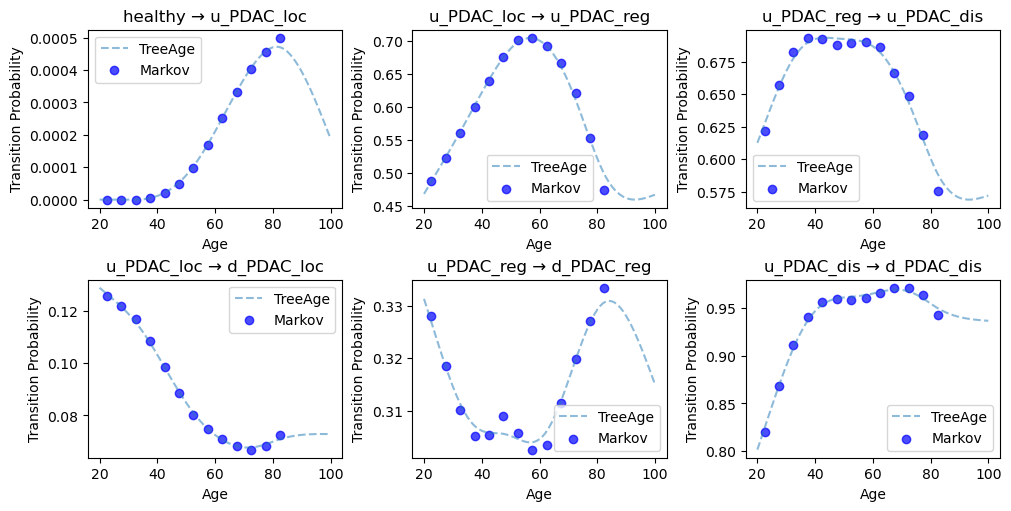

In [31]:
# Anchor with mean at 100 and Smooth interpolation over age
smat = mat[2::5, :, :]
tmat_anchored = np.concatenate([smat, np.minimum(smat[-1:, :, :], np.mean(smat, axis=0, keepdims=True))], axis=0) # take mean of values over age buckets and set at age 100 (only if mean lower than last age bucket)
tmat = csaps([22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5], smat, smooth=0.5, axis=0)(np.linspace(20,100,81)) # interpolation without anchoring
tmat_anchored = csaps([22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5,100], tmat_anchored, smooth=0.01, axis=0)(np.linspace(20,100,81)).clip(0.0, 1.0)
plot_params(smat, tmat_anchored, show_plot=True)

C:\Users\sophi\AppData\Local\Temp\ipykernel_49792\911238997.py:8: RuntimeWarning: divide by zero encountered in divide
  scaling_factors = np.clip(1 / non_diag_sum, None, 1)


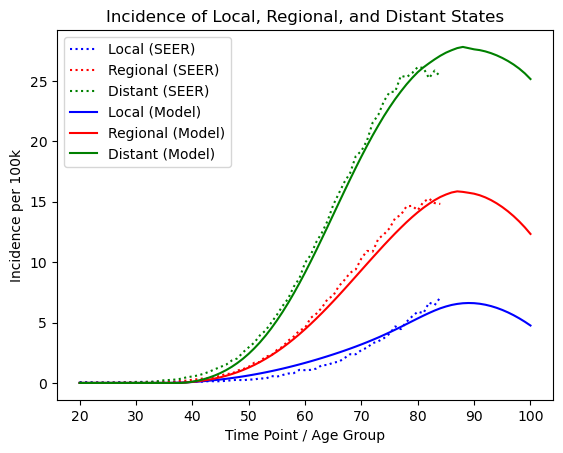

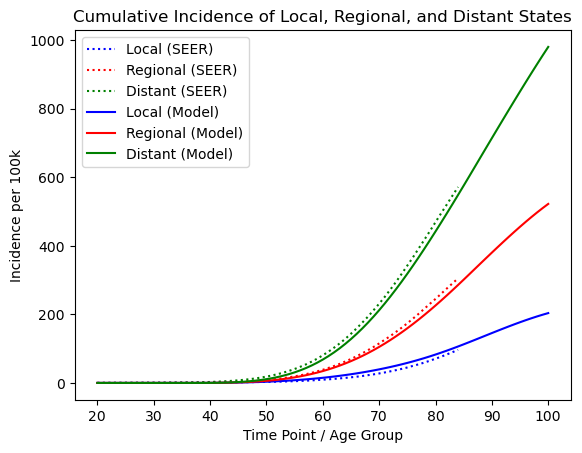

In [27]:
new = add_csd(tmat_anchored)
new = add_acm(tmat_anchored)
new = row_normalize(tmat_anchored)
log = run_markov(tmat_anchored)
p.plot_vs_seer(log[0], seer_inc=c.seer_inc_1y_avg)
p.plot_vs_seer_cumulative(log[0], seer_inc=c.seer_inc_1y_avg)

In [ ]:
new = add_csd(tmat_anchored)
new = add_acm(tmat_anchored)
new = row_normalize(tmat_anchored)
log = run_markov(tmat_anchored)
p.plot_vs_seer(log[0], seer_inc=c.seer_inc_1y_avg)
p.plot_vs_seer_cumulative(log[0], seer_inc=c.seer_inc_1y_avg)

In [ ]:
# Anchor with mean at 100 and Smooth interpolation over age
tmat_anchored = np.concatenate([mat, np.minimum(mat[-1:, :, :], np.mean(mat, axis=0, keepdims=True))], axis=0) # take mean of values over age buckets and set at age 100 (only if mean lower than last age bucket)
tmat = csaps([25,35,45,52.5,57.5,62.5,67.5,72.5,77.5,82.5], mat, smooth=0.01, axis=0)(np.linspace(20,100,81)) # interpolation without anchoring
tmat_anchored = csaps([25,35,45,52.5,57.5,62.5,67.5,72.5,77.5,82.5,100], tmat_anchored, smooth=0.01, axis=0)(np.linspace(20,100,81)).clip(0.0, 1.0)

# If smoothed tmat is exp increasing towards end, used anchored probs
increasing_at_100 = tmat[-2:-1, :, :] < tmat[-1:, :, :]
tmat_anchored = np.where(increasing_at_100, tmat_anchored, tmat)
transition_mask = np.zeros((13, 13), dtype=bool)
from_states, to_states= c.transitions_itos.keys()
transition_mask[from_states, to_states] = True
tmat_anchored = np.where(increasing_at_100 & transition_mask[np.newaxis, ...], tmat_anchored, tmat)

tmat = tmat_anchored
tmat = row_normalize(tmat)